In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from collections import Counter
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

norm = lambda x: (x - x.min())/(x.max()-x.min())

In [2]:
df_biketrips = pd.read_csv('biketrips2011.csv')
df_biketrips['StartTime'] = df_biketrips['StartTime'].astype('datetime64')
df_biketrips['EndTime'] = df_biketrips['EndTime'].astype('datetime64')
df_biketrips['StartNum'] = df_biketrips['StartNum'].astype(int)
df_biketrips['EndNum'] = df_biketrips['EndNum'].astype(int)

In [3]:
list_holidays = pd.read_csv('days_holidays.csv')['datetime'].values.tolist()
list_workdays = pd.read_csv('days_workingdays.csv')['datetime'].values.tolist()

In [4]:
# new features - to help group by hour
df_dhcombo_out = pd.DataFrame({
    'Day': df_biketrips['StartTime'].dt.date,
    'Hour': df_biketrips['StartTime'].dt.hour,
})

df_dhcombo_in = pd.DataFrame({
    'Day': df_biketrips['EndTime'].dt.date,
    'Hour': df_biketrips['EndTime'].dt.hour,
})

df_biketrips['StartHour'] = pd.to_datetime(df_dhcombo_out.Day) + pd.to_timedelta(df_dhcombo_out.Hour, unit='h')
df_biketrips['EndHour'] = pd.to_datetime(df_dhcombo_in.Day) + pd.to_timedelta(df_dhcombo_in.Hour, unit='h')

In [5]:
df_hourly_start = df_biketrips.pivot_table(values='count',index='StartHour',columns='StartNum',aggfunc='sum',fill_value=None)
df_hourly_end = df_biketrips.pivot_table(values='count',index='EndHour',columns='EndNum',aggfunc='sum',fill_value=None)

In [6]:
df_hourly_start['hourofday'] = df_hourly_start.index.hour
df_hourly_start['dayofweek'] = df_hourly_start.index.dayofweek
df_hourly_start['workday'] = df_hourly_start.index.isin(list_workdays)

df_hourly_end['hourofday'] = df_hourly_end.index.hour
df_hourly_end['dayofweek'] = df_hourly_end.index.dayofweek
df_hourly_end['workday'] = df_hourly_end.index.isin(list_workdays)

In [7]:
# take off last 3 columns (added features above)
sites = df_hourly_start.columns[0:len(df_hourly_start.columns)-3]

In [8]:
df_hourly_start['sum_all'] = df_hourly_start[sites].sum(axis=1)
df_hourly_end['sum_all'] = df_hourly_end[sites].sum(axis=1)

In the diagrams below, we can see that there is clearly a difference in usage patterns during weekdays (days 0-4) and weekends (days 5-6). There are two peaks during the workdays (mornings during the 8am hour, afternoons during the 5 and 6pm hour). On weekends, the peak spans across the midday (between noon and 5pm).

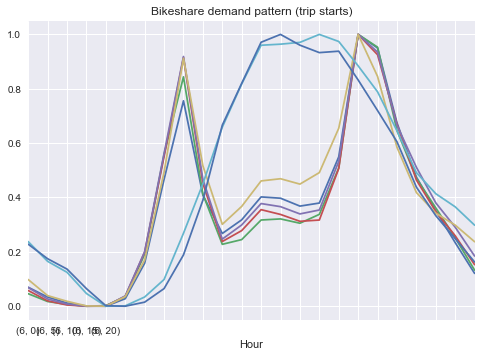

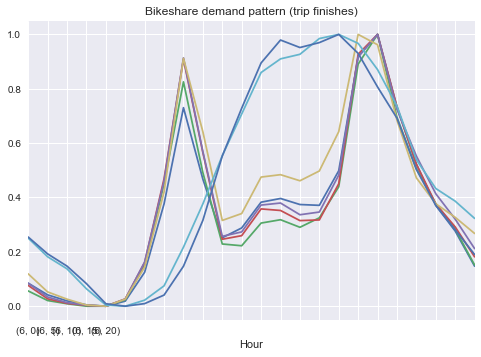

In [9]:
for idx,group in df_hourly_start.groupby(['dayofweek']):
    group.drop('workday',axis=1).groupby(['dayofweek','hourofday']).sum().apply(norm)['sum_all'].plot()

plt.title('Bikeshare demand pattern (trip starts)')
plt.xticks(np.arange(0,24))
plt.xlabel('Hour')
plt.show()

for idx,group in df_hourly_end.groupby(['dayofweek']):
    group.drop('workday',axis=1).groupby(['dayofweek','hourofday']).sum().apply(norm)['sum_all'].plot()

plt.title('Bikeshare demand pattern (trip finishes)')
plt.xticks(np.arange(0,24))
plt.xlabel('Hour')
plt.show()

When visualizing between the trip start and trip finish stats, there is an associated time lag between the trip start and finish. It is noticeably larger on non-workdays, as it appears more casual trips take place during those days.

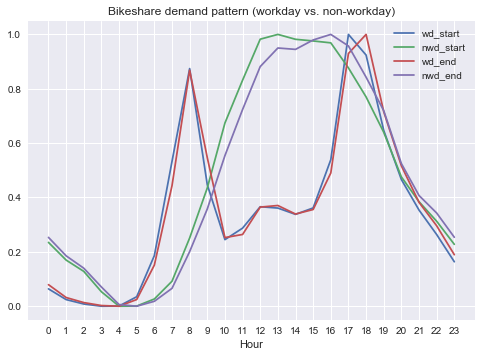

In [10]:
plt.figure()
plt.plot(df_hourly_start[df_hourly_start['workday']==1].groupby('hourofday')[['sum_all']].sum().apply(norm),label='wd_start')
plt.plot(df_hourly_start[df_hourly_start['workday']==0].groupby('hourofday')[['sum_all']].sum().apply(norm),label='nwd_start')
plt.plot(df_hourly_end[df_hourly_end['workday']==1].groupby('hourofday')[['sum_all']].sum().apply(norm),label='wd_end')
plt.plot(df_hourly_end[df_hourly_end['workday']==0].groupby('hourofday')[['sum_all']].sum().apply(norm),label='nwd_end')
plt.legend()
plt.title('Bikeshare demand pattern (workday vs. non-workday)')
plt.xticks(np.arange(0,24))
plt.xlabel('Hour')
plt.show()

In [11]:
df_site_nums = pd.DataFrame(columns=['site','site_start','count_in','count_out','count_net'])

for site in sites:
    site = int(site)
    site_start = df_hourly_start[site].dropna().index[0]
    count_out = df_hourly_start[site].sum()
    count_in = df_hourly_end[site].sum()
    count_net = count_in - count_out
    df_site_nums = df_site_nums.append({'site':site,'site_start':site_start,'count_in':count_in,'count_out':count_out,'count_net':count_net},ignore_index=True)

df_site_nums.set_index('site',inplace=True)

By taking the difference in counts between bike trips which end at a particular station and those that start at a particular station, we can see that a number of stations regularly gain bikes and lose bikes. While this is beyond the scope of the proposed anomaly detection, the anomaly detection algorithm will be able to advise unique situations where the demand is significantly accelerated or deccelerated for a particular time period (based on usage in the past 30 days).

This suggests that quite often, commuters may use the bikeshare in one direction only each day. From an earlier visualization, they are more likely to use the bike in the afternoon rush hour than in the morning, perhaps because the weather is generally warmer and it is easier to shower at home than at work.

In [ ]:
df_site_nums

In [12]:
print('Top 5 Bike Stations Gaining Bikes in 2011')
print((df_hourly_end.sum() - df_hourly_start.sum()).sort_values(ascending=False).nlargest(5))
print()
print('Top 5 Bike Stations Losing Bikes in 2011')
print((df_hourly_end.sum() - df_hourly_start.sum()).sort_values(ascending=False).nsmallest(5))

Top 5 Bike Stations Gaining Bikes in 2011


/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4488: RuntimeWarning: '>' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return_indexers=True)


31200    4817.0
31215    4725.0
31201    3754.0
31217    3482.0
31225    3457.0
dtype: float64

Top 5 Bike Stations Losing Bikes in 2011
31103   -6730.0
31105   -4630.0
31104   -3716.0
31602   -3393.0
31102   -3341.0
dtype: float64


In [13]:
df_hourly_end[[31200,31215,31201,31217,31225]].sum()

EndNum
31200    53910.0
31215    16141.0
31201    36638.0
31217    24281.0
31225    20103.0
dtype: float64

In [14]:
df_hourly_start[[31200,31215,31201,31217,31225]].sum()

StartNum
31200    49093.0
31215    11416.0
31201    32884.0
31217    20799.0
31225    16646.0
dtype: float64

In [17]:
df_std_start = pd.DataFrame(MinMaxScaler().fit_transform(df_hourly_start.fillna(0).iloc[:,:-4]))
df_std_start.index = df_hourly_start.index
df_std_start['hourofday'] = df_std_start.index.hour
df_std_start['dayofweek'] = df_std_start.index.dayofweek
df_std_start['workday'] = df_std_start.index.isin(list_workdays)
df_std_start.columns = df_hourly_start.columns[:-1]

df_std_end = pd.DataFrame(MinMaxScaler().fit_transform(df_hourly_end.fillna(0).iloc[:,:-4]))
df_std_end.index = df_hourly_end.index
df_std_end['hourofday'] = df_std_end.index.hour
df_std_end['dayofweek'] = df_std_end.index.dayofweek
df_std_end['workday'] = df_std_end.index.isin(list_workdays)
df_std_end.columns = df_hourly_end.columns[:-1]


In [18]:
df_heat_start = pd.melt(df_std_start.groupby(['workday','dayofweek','hourofday']).median().reset_index(),id_vars=['hourofday','workday','dayofweek'],value_vars=list(sites),var_name='site')
df_heat_end = pd.melt(df_std_end.groupby(['workday','dayofweek','hourofday']).median().reset_index(),id_vars=['hourofday','workday','dayofweek'],value_vars=list(sites),var_name='site')

In [19]:
df_heat = pd.merge(df_heat_start,df_heat_end,on=['hourofday','workday','dayofweek','site'],suffixes=('_start','_end'))

In [263]:
#plt.figure(figsize=(30,100))
#df_heat_pivot = df_heat.pivot_table(values=['value_start','value_end'],index='site',columns=['workday','hourofday'])
#sns.heatmap(df_heat_pivot)
#plt.show()

In [20]:
df_site_med_pivot = df_heat.pivot_table(values=['value_start','value_end'],index=['hourofday','workday'],columns='site').unstack()
df_site_num_hour_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_site_med_pivot))
df_site_num_hour_norm.columns = df_site_med_pivot.columns

In the following heatmap, we are looking at 4 different daily patterns (all normalized) at each bike station:
<ol>
    <li>Daily incoming trips on non-workdays
    <li>Daily incoming trips on workdays
    <li>Daily outgoing trips on non-workdays
    <li>Daily outgoing trips on workdays
</ol>
<p>
    

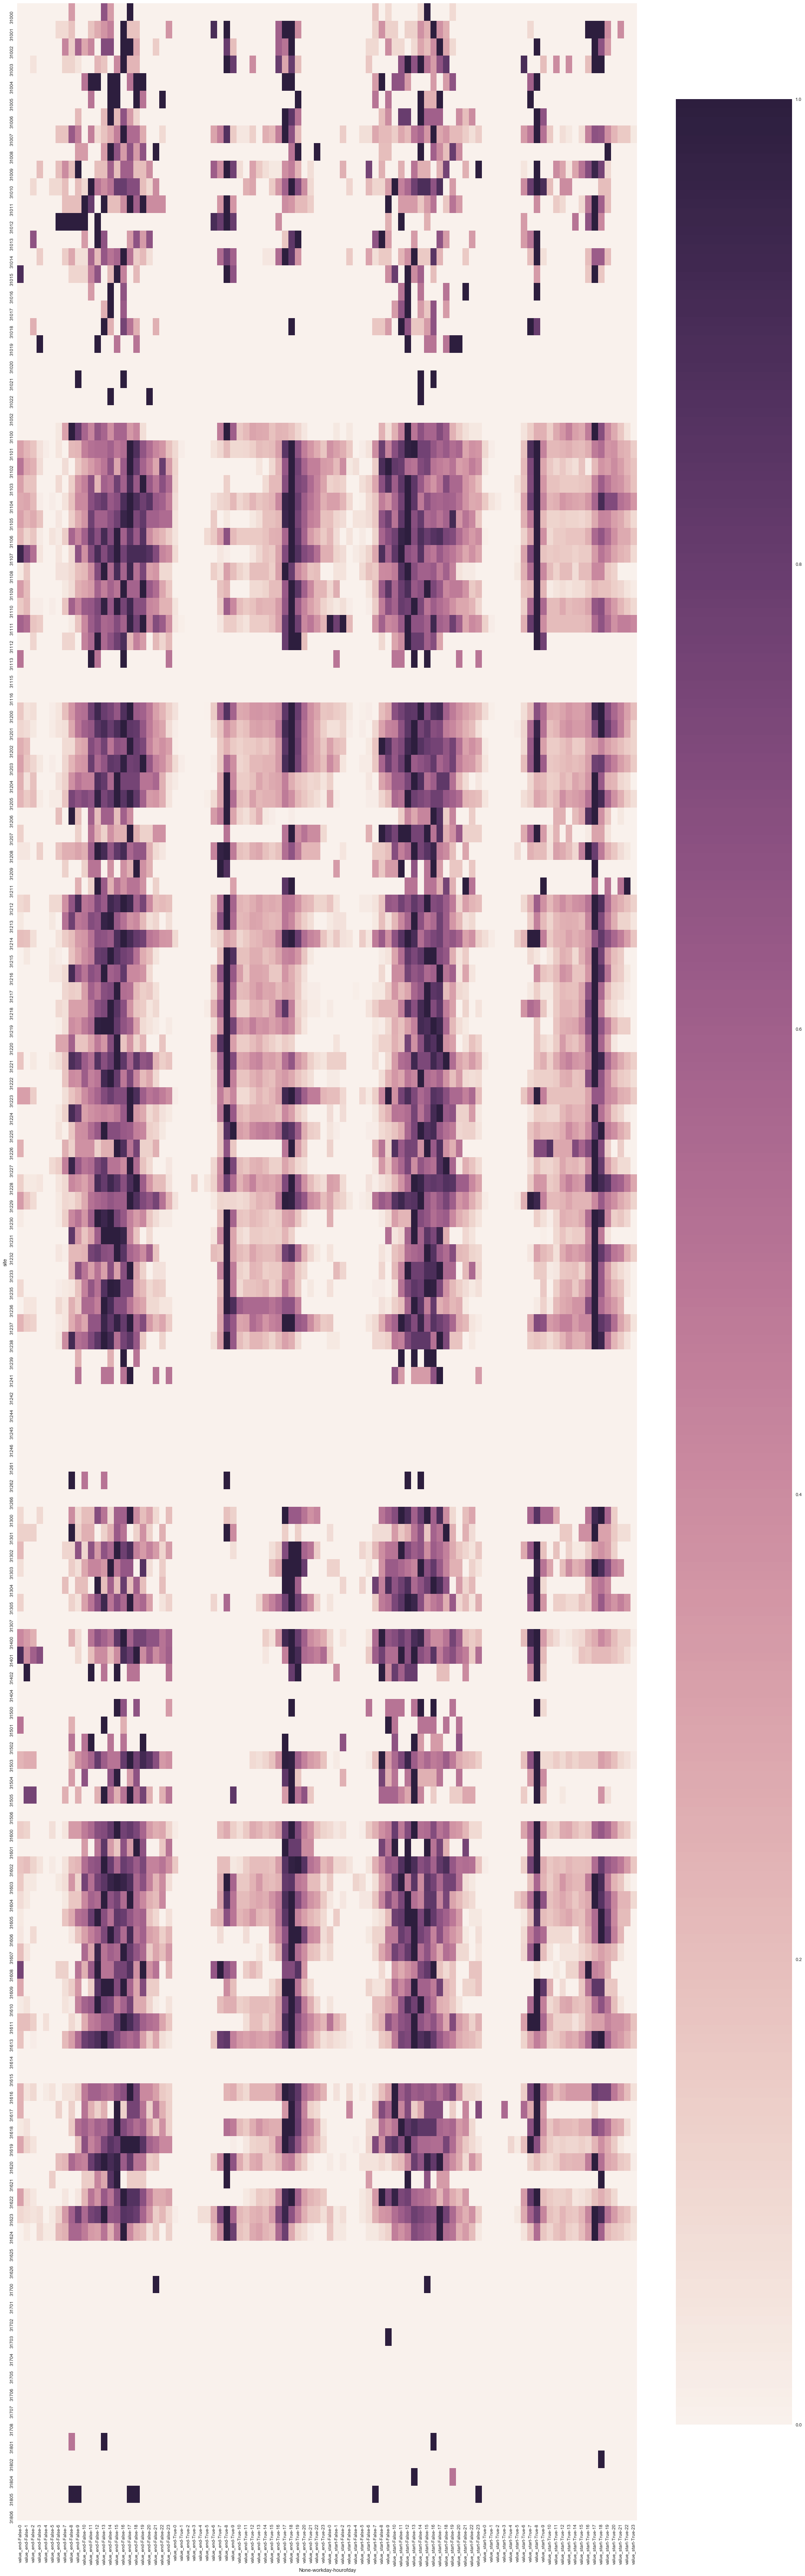

In [21]:
df_site_num_hour_norm.index.name = 'hourofday'
df_site_norm_pivot = df_site_num_hour_norm.stack(level=['site','workday']).reset_index().pivot_table(values=['value_start','value_end'],index='site',columns=['workday','hourofday'])
plt.figure(figsize=(30,100))
sns.heatmap(df_site_norm_pivot)
plt.show()

Below are station-specific usage patterns in select stations, with the left side corresponding to non-workdays and the right side being workdays. Note that any lag here is not related to the duration of the trip, as almost all trips finish at a different station.

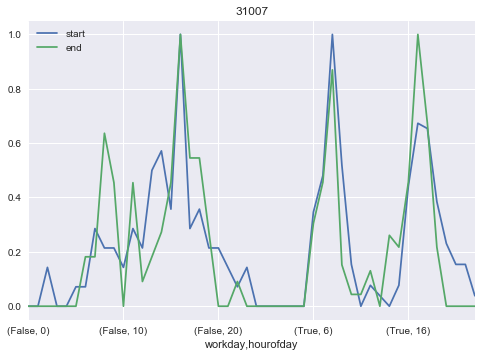

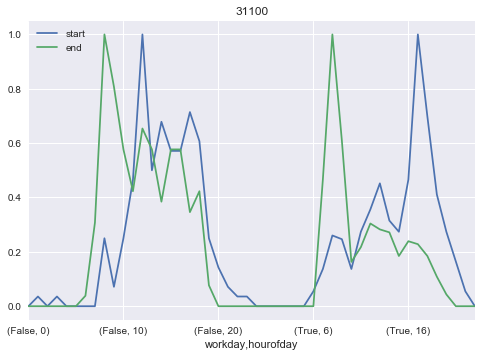

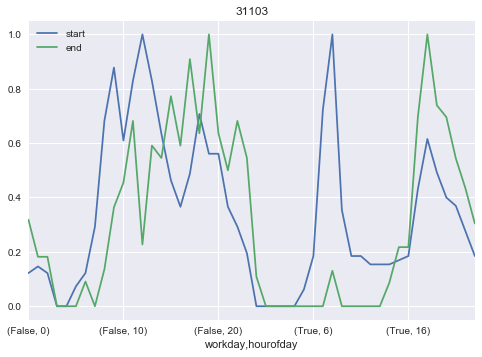

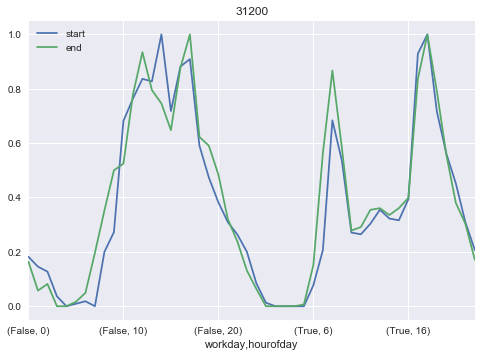

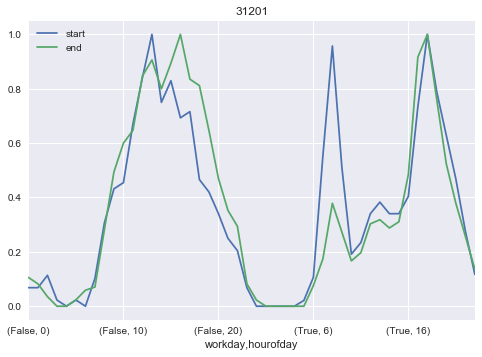

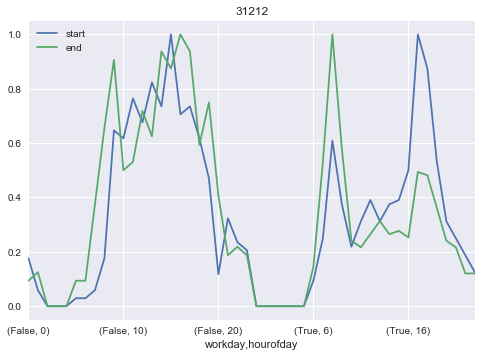

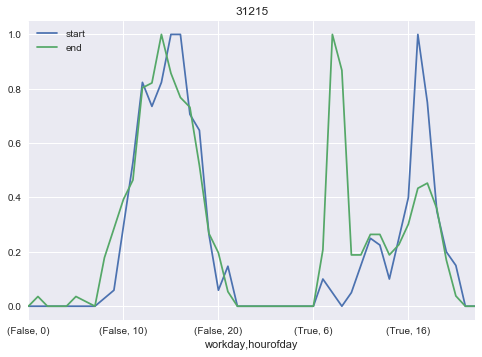

In [22]:
for site in [31007,31100,31103,31200,31201,31212,31215]:
    df_site_norm_pivot.loc[site]['value_start'].plot(label='start')
    df_site_norm_pivot.loc[site]['value_end'].plot(label='end')
    plt.legend()
    plt.title(site)
    plt.show()
